In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# from google.colab import auth
# auth.authenticate_user()

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(VIZWIZ_CAPTION_DIR)

from vizwiz_api.vizwiz import VizWiz

In [ ]:
%cd VIZWIZ_CAPTION_DIR

In [ ]:
import pandas as pd
import re, string, unicodedata
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
DATA_DIR = VIZWIZ_CAPTION_DIR

In [ ]:
ANN_TRAIN = "annotations/train.json"
ANN_VAL   = "annotations/val.json"
ANN_TEST  = "annotations/test.json"

In [ ]:
# load via VizWiz API
vizwiz_train = VizWiz(ANN_TRAIN, ignore_rejected=True, ignore_precanned=True)
vizwiz_val   = VizWiz(ANN_VAL,   ignore_rejected=True, ignore_precanned=True)
# For test, these flags don’t matter (there are no captions), but we keep the call uniform:
# vw_test  = VizWiz(ANN_TEST,  ignore_rejected=True, ignore_precanned=True)


loading annotations into memory...
Done (t=1.64s)
creating index...
index created! imgs = 23431, anns = 100575
loading annotations into memory...
Done (t=0.96s)
creating index...
index created! imgs = 7750, anns = 33145


In [ ]:
# 23431*5

In [ ]:
train_anns = pd.DataFrame(vizwiz_train.dataset["annotations"])
val_anns   = pd.DataFrame(vizwiz_val.dataset["annotations"])

In [ ]:
train_anns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100575 entries, 0 to 100574
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   caption        100575 non-null  object
 1   image_id       100575 non-null  int64 
 2   is_precanned   100575 non-null  bool  
 3   is_rejected    100575 non-null  bool  
 4   id             100575 non-null  int64 
 5   text_detected  100575 non-null  bool  
dtypes: bool(3), int64(2), object(1)
memory usage: 2.6+ MB


In [ ]:
val_anns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33145 entries, 0 to 33144
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   caption        33145 non-null  object
 1   image_id       33145 non-null  int64 
 2   is_precanned   33145 non-null  bool  
 3   is_rejected    33145 non-null  bool  
 4   id             33145 non-null  int64 
 5   text_detected  33145 non-null  bool  
dtypes: bool(3), int64(2), object(1)
memory usage: 874.1+ KB


In [ ]:
train_anns.head()

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,A bottle of spices in a plastic container layi...,0,False,False,3,True
3,some basil leaves in a container on a counter,0,False,False,4,True
4,A can of Coca Cola on a counter is shown for w...,1,False,False,5,True


In [ ]:
train_imgs = pd.DataFrame(vizwiz_train.dataset["images"]).rename(columns={"id":"image_id"})[["image_id","file_name"]]

# keep images with >= 1 caption
train_anns_ = train_anns[["image_id","caption"]].dropna()
df_train_grouped = (
    train_anns_
    .groupby("image_id", as_index=False)["caption"].agg(list)   # list of captions per image
    .merge(train_imgs, on="image_id", how="inner")
)
df_train_grouped = df_train_grouped[df_train_grouped["caption"].map(len) > 0].reset_index(drop=True)

In [ ]:
df_train_grouped.iloc[0]["caption"]

['ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.',
 'A green and white plastic condiment bottle containing Basil leaves.',
 'A bottle of spices in a plastic container laying on a surface.',
 'some basil leaves in a container on a counter']

In [ ]:
val_imgs   = pd.DataFrame(vizwiz_val.dataset["images"]).rename(columns={"id":"image_id"})[["image_id","file_name"]]

val_anns_any = val_anns[["image_id","caption"]].dropna()
df_val_grouped = (
    val_anns_any
    .groupby("image_id", as_index=False)["caption"].agg(list)
    .merge(val_imgs, on="image_id", how="inner")
).reset_index(drop=True)

#  “exactly 5 captions” – recommended for metrics to match common protocols
df_val_grouped = df_val_grouped[df_val_grouped["caption"].map(len) == 5].reset_index(drop=True)

In [ ]:
df_val_grouped.iloc[0]["caption"]

['A computer screen shows a repair prompt on the screen.',
 'a computer screen with a repair automatically pop up',
 'partial computer screen showing the need of repairs',
 'Part of a computer monitor showing a computer repair message.',
 'The top of a laptop with a blue background and dark blue text.']

In [ ]:
def clean_caption(
    text,
    lower = True,
    normalize_unicode = True,
    strip_punct = True,
    keep_nums = True,
    keep_single_letters = False, #
    keep_a_and_i = True,
    keep_stopwords = True,
    collapse_whitespace = True,
    min_tokens = 1
):
    t = text
    if t is None:
        return ""
    if lower:
        t = t.lower()
    if normalize_unicode:
        t = unicodedata.normalize("NFKC", t)
    if strip_punct:
        t = t.translate(str.maketrans("", "", string.punctuation))
    if not keep_nums:
        t = re.sub(r"\d+", "", t)

    tokens = t.split()
    if not keep_single_letters:
        if keep_a_and_i:
            tokens = [w for w in tokens if (len(w) > 1) or (w in ["a", "i"])]
        else:
            tokens = [w for w in tokens if len(w) > 1]

    if not keep_stopwords:
        stopwords = set(nltk.corpus.stopwords.words("english"))
        tokens = [w for w in tokens if w not in stopwords]

    if collapse_whitespace:
        t = " ".join(tokens).strip()
    else:
        t = " ".join(tokens)

    if min_tokens > 0:
        if len(t.split()) < min_tokens:
            t = ""

    return t




In [ ]:
df_train_grouped["caption_clean"] = df_train_grouped["caption"].map(lambda x: [clean_caption(c) for c in x])
df_val_grouped["caption_clean"] = df_val_grouped["caption"].map(lambda x: [clean_caption(c) for c in x])

In [ ]:
# start from grouped with columns: image_id, file_name, caption_clean (list)
df_train_long = (
    df_train_grouped[["image_id","file_name","caption_clean"]]
    .explode("caption_clean", ignore_index=True)
)

df_val_long = (
    df_val_grouped[["image_id","file_name","caption_clean"]]
    .explode("caption_clean", ignore_index=True)
)


count     100575.000000
min            5.000000
max          110.000000
mean          12.002416
std            4.245759
median        11.000000
p90           17.000000
p95           20.000000
p99           28.000000
dtype: float64


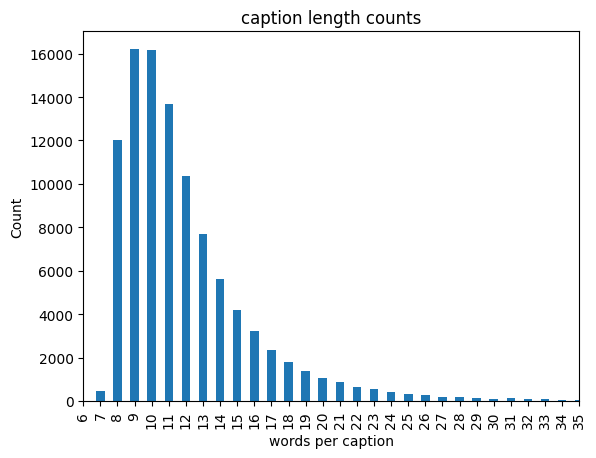

In [ ]:
# choosing best caption length for computaiton cost vs relevance
def length_stats(df, col="caption_clean"):
    lens = df[col].str.split().map(len)
    out = pd.Series({
        "count": int(lens.size),
        "min":   int(lens.min()),
        "max":   int(lens.max()),
        "mean":  float(lens.mean()),
        "std":   float(lens.std()),
        "median":float(lens.median()),
        "p90":   int(lens.quantile(0.90)),
        "p95":   int(lens.quantile(0.95)),
        "p99":   int(lens.quantile(0.99)),
    })
    return lens, out

train_lens, train_stats = length_stats(df_train_long)
print(train_stats)
vc_train = train_lens.value_counts().sort_index()

plt.figure()
vc_train.plot(kind="bar")
plt.title("caption length counts")
plt.xlabel("words per caption")
plt.xlim(1,30)
plt.ylabel("Count")
plt.show()

In [ ]:
max_len_text = 20 + 2 # + 2 for start and end tokens

In [ ]:
# setup for removing words that arent frequent across all captions

# one word per row
train_words = df_train_long["caption_clean"].str.split().explode().dropna().astype(str)

# frequency of each word
freq = train_words.value_counts()

# quick stats over "counts per word"
vocab_stats = pd.Series({
    "unique_words": int(freq.size),
    "total_tokens": int(freq.sum()),
    "mean_per_word": float(freq.mean()),
    "median_per_word": float(freq.median()),
    "p90_per_word": float(freq.quantile(0.90)),
    "p95_per_word": float(freq.quantile(0.95)),
    "p99_per_word": float(freq.quantile(0.99)),
})
print(vocab_stats)


unique_words       1.895700e+04
total_tokens       1.207143e+06
mean_per_word      6.367796e+01
median_per_word    3.000000e+00
p90_per_word       4.200000e+01
p95_per_word       1.080000e+02
p99_per_word       7.486400e+02
dtype: float64


In [ ]:
thresholds = [i for i in range(1, 13)]
summary = pd.DataFrame({
    "min_count": thresholds,
    "vocab_size": [(freq >= t).sum() for t in thresholds],
    "coverage_tokens_%": [100 * freq[freq >= t].sum() / freq.sum() for t in thresholds],
})
summary


,min_count,vocab_size,coverage_tokens_%
0,1,18957,100.000000
1,2,12167,99.437515
2,3,9611,99.014036
3,4,8092,98.636533
4,5,7053,98.292249
5,6,6284,97.973728
6,7,5749,97.707811
7,8,5334,97.467160
8,9,4969,97.225267
9,10,4688,97.015764


In [ ]:
min_word_count = 10

In [ ]:
keep_vocab = set(freq[freq >= min_word_count].index)

In [ ]:
def map_rare_words_to_unk(s):
    return " ".join(w if w in keep_vocab else "<unk>" for w in s.split())

# new columns with mapped text
df_train_long["caption_mapped"] = df_train_long["caption_clean"].map(map_rare_words_to_unk)
df_val_long["caption_mapped"]   = df_val_long["caption_clean"].map(map_rare_words_to_unk)


In [ ]:
unk_rate = (df_train_long["caption_mapped"].str.split().explode().eq("<unk>").mean())
print(f"UNK rate (train): {unk_rate:.2%}")


UNK rate (train): 2.98%


In [ ]:
# ends up lowering vocab from 18957 to ~4690, only lose ~3% of total words for ~/4 vocab size

In [ ]:
START, END = "startcap", "endcap"

df_train_long["caption_final"] = START + " " + df_train_long["caption_mapped"] + " " + END
df_val_long["caption_final"]   = START + " " + df_val_long["caption_mapped"]   + " " + END


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<unk>", filters="")  # don't filter; we already cleaned
tokenizer.fit_on_texts(df_train_long["caption_final"])

vocab_size = len(tokenizer.word_index) + 1
start_id = tokenizer.word_index[START]
end_id   = tokenizer.word_index[END]
unk_id   = tokenizer.word_index["<unk>"]
print("vocab_size:", vocab_size, "| ids:", {"startcap": start_id, "endcap": end_id, "<unk>": unk_id})


vocab_size: 4692 | ids: {'startcap': 3, 'endcap': 4, '<unk>': 8}


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def texts_to_padded(texts, tok, end_id, max_len_total):
    seqs = tok.texts_to_sequences(texts)
    fixed = []
    for s in seqs:
        # remove the existing end if present
        if s and s[-1] == end_id:
            core = s[:-1]
        else:
            core = s
        # keep room for exactly one END
        core = core[:max_len_total - 1]
        s = core + [end_id]
        fixed.append(s)
    return pad_sequences(fixed, maxlen=max_len_total, padding="post", truncating="post")


X_train = texts_to_padded(df_train_long["caption_final"].tolist(), tokenizer, end_id, max_len_text)
X_val   = texts_to_padded(df_val_long["caption_final"].tolist(), tokenizer, end_id, max_len_text)

In [ ]:
seq = X_train[0] # shape: (max_len_text,)
print("IDS:", seq.tolist())

# detokenize (Tokenizer ignores 0 pads)
print("TEXT:", tokenizer.sequences_to_texts([seq])[0])

IDS: [3, 95, 11, 2, 1591, 395, 47, 95, 228, 7, 1908, 929, 458, 4, 0, 0, 0, 0, 0, 0, 0, 0]
TEXT: startcap its is a basil leaves container its contains the net weight too endcap <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [ ]:
## vocab changed? padding did this?
print(vocab_size)
print(X_train.max() + 1)
vocab_size = X_train.max() + 1

4692
4693


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
def build_encoder(img_size=299, feat_layer="mixed7", proj_dim=512, freeze=True):

    # Input layer for the image
    image_input = layers.Input(shape=(img_size, img_size, 3), name="image_input")

    # Load InceptionV3 base model pre-trained on ImageNet
    base = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_tensor=image_input)

    # Freeze base model layers if specified
    if freeze:
        for l in base.layers:
            l.trainable = False

    # Get features from the specified layer
    feat_map = base.get_layer(feat_layer).output

    # Project features to `proj_dim`
    proj = layers.Conv2D(proj_dim, 1, activation="relu", name="enc_proj")(feat_map)

    # Reshape features into a sequence
    s = proj.shape[1] * proj.shape[2]  # H*W
    enc_seq = layers.Reshape((s, proj_dim), name="encoder_seq")(proj)  # (B, S, D)

    return Model(image_input, enc_seq, name="encoder")

In [ ]:
def build_decoder(vocab_size, max_len_text, emb_dim=256, rnn_units=512):
    # Inputs
    features_in = layers.Input(shape=(None, 512), name="features_in")   # (B, S, D)
    dec_in = layers.Input(shape=(max_len_text-1,), name="decoder_in")  # (B, T)

    # Trainable word embeddings (Option 1) # mask_zero true already handled, error if true
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=False, name="word_embedding")(dec_in)  # (B, T, E)

    # Decoder RNN (returns sequence)
    h_seq = layers.GRU(rnn_units, return_sequences=True, name="decoder_gru")(x)               # (B, T, H)

    # Bahdanau/Additive attention: queries=h_seq, values=features
    # Keras AdditiveAttention handles (B, T, H) queries vs (B, S, D) values via projection.
    context = layers.AdditiveAttention(name="bahdanau_attn")([h_seq, features_in])            # (B, T, D)

    # Fuse decoder state + context, then project to vocab per timestep
    fuse = layers.Concatenate(name="fuse")([h_seq, context])                                   # (B, T, H+D)
    # old softmax
    # hidden = layers.TimeDistributed(layers.Dense(rnn_units, activation="relu"), name="td_dense")(fuse)
    # logits = layers.TimeDistributed(layers.Dense(vocab_size, activation="softmax"), name="td_softmax")(hidden)
    hidden = layers.TimeDistributed(layers.Dense(rnn_units, activation="relu"), name="td_dense")(fuse)
    logits = layers.TimeDistributed(layers.Dense(vocab_size), name="td_logits")(hidden)


    return Model([features_in, dec_in], logits, name="decoder")


In [ ]:
img_size = 299
encoder = build_encoder(img_size=img_size, feat_layer="mixed7", proj_dim=512, freeze=True)
decoder = build_decoder(vocab_size=vocab_size, max_len_text=max_len_text, emb_dim=256, rnn_units=512)

img_in  = encoder.input
feats   = encoder.output # (B, S, 512)
dec_in  = layers.Input(shape=(max_len_text-1,), name="decoder_in")  # (B, T)
y_seq   = decoder([feats, dec_in]) # (B, T, V)

model = Model([img_in, dec_in], y_seq, name="caption_model")

model.encoder=encoder

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "caption_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 14,685,941 (56.02 MB)

 Trainable params: 5,710,677 (21.78 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [ ]:
from google.colab import auth
import os
auth.authenticate_user()

# Placeholder for your GCS bucket name
GCS_PROJECT_ID = "your-gcp-project-id"
GCS_BUCKET_NAME = "your-gcs-bucket-name"

# Update project config
!gcloud config set project {GCS_PROJECT_ID}

# Local folders on the Colab VM (placeholders)
LOCAL_TRAIN_IMAGES_DIR = "/content/train"
LOCAL_VAL_IMAGES_DIR   = "/content/val"

!mkdir -p "{LOCAL_TRAIN_IMAGES_DIR}"
!mkdir -p "{LOCAL_VAL_IMAGES_DIR}"

# Sync once from GCS → local (using placeholder bucket and local dirs)
TRAIN_IMAGE_ROOT = f"gs://{GCS_BUCKET_NAME}/train"
VAL_IMAGE_ROOT   = f"gs://{GCS_BUCKET_NAME}/val"

!gsutil -m rsync -r "{TRAIN_IMAGE_ROOT}" "{LOCAL_TRAIN_IMAGES_DIR}"
!gsutil -m rsync -r "{VAL_IMAGE_ROOT}"   "{LOCAL_VAL_IMAGES_DIR}"

# Now override roots to point to local copies
TRAIN_IMAGE_ROOT = LOCAL_TRAIN_IMAGES_DIR
VAL_IMAGE_ROOT   = LOCAL_VAL_IMAGES_DIR

train_paths = (TRAIN_IMAGE_ROOT + "/" + df_train_long["file_name"]).to_numpy()
val_paths   = (VAL_IMAGE_ROOT   + "/" + df_val_long["file_name"]).to_numpy()


In [ ]:
import os

IMG_SIZE = 299
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess
# save image


def preprocess_image(path):
    img = tf.io.read_file(path)                    # works with gs://
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return iv3_preprocess(img)                     # InceptionV3 preprocessing

# full caption length (incl. [start] and [end])
T_total = max_len_text
T = T_total - 1   # decoder timesteps

def load_and_pack(path, seq):
    """
    seq is shape (T_total,) = [start, w1, ..., w_{T-1}, end, 0, 0, ...]
    We build:
      dec_in  = [start, w1, ..., w_{T-1}]   (T,)
      dec_tgt = [w1, ..., w_{T-1}, end]     (T,)
    """
    img = preprocess_image(path)
    dec_in  = seq[:-1]    # (T,)
    dec_tgt = seq[1:]     # (T,)
    return (img, dec_in), dec_tgt

def make_dataset(paths, X, batch_size=64, shuffle=True, cache_path=None):
    ds = tf.data.Dataset.from_tensor_slices((paths, X))

    if shuffle:
        ds = ds.shuffle(
            buffer_size=min(len(X), 8192),
            reshuffle_each_iteration=True
        )

    ds = ds.map(
        load_and_pack,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )

    ds = ds.batch(batch_size)

    if cache_path is not None:
        # Delete the lockfile if it exists before caching
        lockfile = cache_path + '_0.lockfile'
        if os.path.exists(lockfile):
            print(f"Deleting old cache lockfile: {lockfile}")
            os.remove(lockfile)
        ds = ds.cache(cache_path)   # first epoch fills, later epochs are fast

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# 1) Build datasets with cache enabled
train_ds = make_dataset(
    train_paths, X_train,
    batch_size=64,
    shuffle=True,
    cache_path=LOCAL_TRAIN_CACHE_PATH,
)

val_ds = make_dataset(
    val_paths, X_val,
    batch_size=64,
    shuffle=False,
    cache_path=LOCAL_VAL_CACHE_PATH,
)

# 2) FORCE a full pass over train/val to fill the caches
for _ in train_ds:
    pass

for _ in val_ds:
    pass

print("Caches warmed.")

# 3) (Optional but clean) Rebuild datasets that reuse the same cache files
train_ds = make_dataset(
    train_paths, X_train,
    batch_size=64,
    shuffle=True,
    cache_path=LOCAL_TRAIN_CACHE_PATH,
)

val_ds = make_dataset(
    val_paths, X_val,
    batch_size=64,
    shuffle=False,
    cache_path=LOCAL_VAL_CACHE_PATH,
)

Caches warmed.


In [ ]:
# Take one batch from the training dataset to inspect tensor shapes
for (imgs, dec_in), dec_tgt in train_ds.take(1):
    print("imgs   :", imgs.shape)
    print("dec_in :", dec_in.shape)
    print("dec_tgt:", dec_tgt.shape)

imgs   : (64, 299, 299, 3)
dec_in : (64, 21)
dec_tgt: (64, 21)


In [ ]:
MODEL_DIR = f"gs://{GCS_BUCKET_NAME}/vizwiz_models/v1"

from tensorflow.keras import callbacks

# file patterns on GCS
CKPT_BEST = MODEL_DIR + "/best_val_loss.weights.h5"
CKPT_EPOCH = MODEL_DIR + "/epoch_{epoch:02d}_val{val_loss:.3f}.weights.h5"

checkpoint_best = callbacks.ModelCheckpoint(
    CKPT_BEST,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1,
)

checkpoint_every_epoch = callbacks.ModelCheckpoint(
    CKPT_EPOCH,
    save_weights_only=True,
    save_best_only=False,   # save EVERY epoch
    monitor="val_loss",    
    mode="min",
    verbose=1,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
)

class UnfreezeFrom(callbacks.Callback):
    def __init__(self, start_from_layer="mixed7", at_epoch=2):
        super().__init__()
        self.start_from_layer = start_from_layer
        self.at_epoch = at_epoch
        self.already_unfrozen = False

    def on_epoch_begin(self, epoch, logs=None):
        # Do nothing after first unfreeze
        if self.already_unfrozen:
            return

        if epoch == self.at_epoch:
            enc = self.model.encoder 
            start = False
            n = 0

            for l in enc.layers:
                if l.name == self.start_from_layer:
                    start = True
                if start:
                    if isinstance(l, tf.keras.layers.BatchNormalization):
                        l.trainable = False
                    else:
                        l.trainable = True
                        n += 1

            self.already_unfrozen = True
            print(f"[Unfreeze] {n} layers unfrozen from '{self.start_from_layer}' upward (BN frozen).")

unfreeze_cb = UnfreezeFrom(start_from_layer="mixed7", at_epoch=2)

cbs = [unfreeze_cb, checkpoint_best, checkpoint_every_epoch, reduce_lr, early_stop]

In [ ]:
# sanity checks

In [ ]:
# for (imgs, dec_in), dec_tgt in train_ds.take(1):
#     print("imgs shape:    ", imgs.shape)      # (B, 299, 299, 3)
#     print("dec_in shape:  ", dec_in.shape)    # (B, T)
#     print("dec_tgt shape: ", dec_tgt.shape)   # (B, T)


In [ ]:
# (logits) = model([imgs, dec_in])
# print(logits.shape)  # should be (64, 21, vocab_size)


In [ ]:
# i = 0
# print("First decoder input ids:", dec_in[i].numpy().tolist())
# print("First target ids:       ", dec_tgt[i].numpy().tolist())

# print("Dec_in text:", tokenizer.sequences_to_texts([dec_in[i].numpy()])[0])
# print("Dec_tgt text:", tokenizer.sequences_to_texts([dec_tgt[i].numpy()])[0])


In [ ]:
CKPT_BEST = MODEL_DIR + "/best_val_loss.weights.h5"

# Load pre-trained weights from the best model checkpoint
model.load_weights(CKPT_BEST)
print("Loaded weights from best_val_loss.weights.h5")

In [ ]:
import tensorflow as tf

enc = model.encoder   # the full encoder model
# manally unfreeze

start = False
n = 0

for l in enc.layers:
    if l.name == "mixed7":
        start = True
    if start:
        if isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = False
        else:
            l.trainable = True
            n += 1

print(f"[Manual unfreeze] {n} layers trainable from 'mixed10' (BN frozen).")


[Manual unfreeze] 3 layers trainable from 'mixed10' (BN frozen).


In [ ]:
# Define the number of training epochs
EPOCHS = 10

# Train the model using the prepared datasets and callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
)

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess

# --- Placeholder Variables ---
# Directory containing VizWiz caption data (annotations, images).
# This should be a path accessible to your Colab environment or linked from Google Drive.
VIZWIZ_CAPTION_DIR = "/path/to/vizwiz_caption_directory"

# GCS bucket name for storing images and model checkpoints.
GCS_BUCKET_NAME = "your-gcs-bucket-name"

# Local directories where training and validation images will be synced.
LOCAL_TRAIN_IMAGES_DIR = "/path/to/local_train_images"
LOCAL_VAL_IMAGES_DIR   = "/path/to/local_val_images"

# Local cache paths for TensorFlow datasets.
LOCAL_TRAIN_CACHE_PATH = "/path/to/local_train_cache"
LOCAL_VAL_CACHE_PATH   = "/path/to/local_val_cache"

# Local path to save BLEU scores before uploading to GCS.
LOCAL_BLEU_SCORES_PATH = "/path/to/bleu_scores.json"

VAL_IMAGE_ROOT = LOCAL_VAL_IMAGES_DIR
START_TOKEN = "startcap"
END_TOKEN   = "endcap"

# from tokenizer setup
# tokenizer, start_id, end_id, vocab_size, max_len_text, df_val_long all exist
index_word = tokenizer.index_word    # {id: word}
PAD_ID = 0

IMG_SIZE = 299

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return iv3_preprocess(img)

def generate_caption_for_path(img_path, model, tokenizer, max_len_text, start_id, end_id):
    # 1) Preprocess image
    img = preprocess_image(img_path)
    img = tf.expand_dims(img, 0)  # (1, 299, 299, 3)

    T = max_len_text - 1
    seq = [start_id]  # list of token IDs, starting with startcap

    for t in range(T):
        dec_in = tf.keras.preprocessing.sequence.pad_sequences(
            [seq], maxlen=T, padding="post", truncating="post"
        )  # (1, T)

        logits = model.predict([img, dec_in], verbose=0)  # (1, T, V)

        cur_len = len(seq)
        step_logits = logits[0, cur_len - 1]  # (V,)
        next_id = int(tf.argmax(step_logits).numpy())

        if next_id == end_id or next_id == PAD_ID:
            break

        seq.append(next_id)

    # Convert IDs  words (skip special tokens)
    words = []
    for tid in seq:
        if tid in (start_id, end_id, PAD_ID):
            continue
        word = index_word.get(tid, "<unk>")
        words.append(word)

    return " ".join(words)

In [ ]:
# !pip install nltk
import nltk

# Import sentence_bleu for individual sentence scoring and SmoothingFunction for handling zero matches
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Initialize a smoothing function (Method 1) to avoid division by zero for short or low-matching captions
smooth = SmoothingFunction().method1

In [ ]:
import random

def clean_caption_text(text):
    # remove start/end tokens from GT captions
    return text.replace(START_TOKEN, "").replace(END_TOKEN, "").strip()

# pick a random val image (or use iloc[0])
i = random.randrange(len(df_val_long))
row = df_val_long.iloc[i]

fname = row["file_name"]
img_path = os.path.join(VAL_IMAGE_ROOT, fname)

print("Image file:", img_path)

# predicted caption
pred = generate_caption_for_path(
    img_path,
    model,
    tokenizer,
    max_len_text,
    start_id,
    end_id,
)
print("\nPRED:", pred)

# collect all refs for that image
all_caps = df_val_long[df_val_long["file_name"] == fname]["caption_final"].tolist()
refs_tokens = []

for c in all_caps:
    c_clean = clean_caption_text(c)
    refs_tokens.append(c_clean.split())

print("\nREFS:")
for r in refs_tokens:
    print(" -", " ".join(r))

# BLEU for that one image
hyp_tokens = pred.split() if pred.strip() else ["<empty>"]
single_bleu = sentence_bleu(refs_tokens, hyp_tokens, smoothing_function=smooth)
print(f"\nSingle-image BLEU: {single_bleu:.4f}")



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.auto import tqdm  # works nicely in Colab/Notebooks

# group df_val_long: file_name -> list of captions
groups = df_val_long.groupby("file_name")["caption_final"].apply(list).reset_index()
print("Num unique val images:", len(groups))

refs = []  # references: list of list-of-token-lists
hyps = []  # hypotheses: list of token lists

MAX_EVAL = None  # or e.g. 500 if you want a quick run

# decide how many we'll process (for tqdm total)
total = len(groups) if MAX_EVAL is None else min(len(groups), MAX_EVAL)

for idx, row in tqdm(groups.iterrows(), total=total):
    if MAX_EVAL is not None and idx >= MAX_EVAL:
        break

    fname = row["file_name"]
    caps  = row["caption_final"]  # list of captions

    img_path = os.path.join(VAL_IMAGE_ROOT, fname)

    # 1) prediction
    pred_sentence = generate_caption_for_path(
        img_path,
        model,
        tokenizer,
        max_len_text,
        start_id,
        end_id,
    )
    hyp_tokens = pred_sentence.split() if pred_sentence.strip() else ["<empty>"]

    # 2) references
    img_refs = []
    for c in caps:
        c_clean = clean_caption_text(c)
        img_refs.append(c_clean.split())

    refs.append(img_refs)
    hyps.append(hyp_tokens)

print("Scored examples:", len(hyps))


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smooth = SmoothingFunction().method1

bleu1 = corpus_bleu(refs, hyps, weights=(1.0, 0.0, 0.0, 0.0), smoothing_function=smooth)
bleu2 = corpus_bleu(refs, hyps, weights=(0.5, 0.5, 0.0, 0.0), smoothing_function=smooth)
bleu3 = corpus_bleu(refs, hyps, weights=(1/3, 1/3, 1/3, 0.0), smoothing_function=smooth)
bleu4 = corpus_bleu(refs, hyps, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")


BLEU-1: 0.5707
BLEU-2: 0.3846
BLEU-3: 0.2516
BLEU-4: 0.1604


In [ ]:
MODEL_DIR = f"gs://{GCS_BUCKET_NAME}/vizwiz_models/v1"

import json
import os

scores = {
    "bleu1": float(bleu1),
    "bleu2": float(bleu2),
    "bleu3": float(bleu3),
    "bleu4": float(bleu4),
    "num_examples": len(hyps),
}

local_path = LOCAL_BLEU_SCORES_PATH

with open(local_path, "w") as f:
    json.dump(scores, f, indent=2)

print("Saved local:", local_path)

remote_path = f"{MODEL_DIR}/bleu_scores.json"
!gsutil cp "{local_path}" "{remote_path}"
print("Uploaded to:", remote_path)

# used to disconnect from a100 after completion
# from google.colab import runtime
# runtime.unassign()